In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG
from IPython.display import display

In [2]:
#Берем файл со всеми дескрипторами (Из той папки, где код)
data = pd.read_excel('C://Users//plato//Documents//Python Scripts//Toluene_final//Toluene_ALL.xlsx', index_col=0) 

In [3]:
merged_df = data[['VE1_RG', 'G3u:(Dragon7)', 'MATS8i:(Dragon7)', 'TDB06p:(Dragon7)', 'X', 'Eig03_EA(dm)', 'Mor23i:(Dragon7)', 'LnLn']]

In [4]:
#Сохраняем в отдельный файл (он сохранится в ту папку, в которой этот код)
merged_df.to_excel(f'Toluene_SVR.xlsx', index=True)

In [5]:
Porphs_data = pd.read_excel('C://Users//plato//Documents//Python Scripts//Toluene_final//Toluene_SVR.xlsx', index_col=0)
Porphs_data.head()

,VE1_RG,G3u:(Dragon7),MATS8i:(Dragon7),TDB06p:(Dragon7),X,Eig03_EA(dm),Mor23i:(Dragon7),LnLn
SrNo,,,,,,,,
1,3.739,1.000,0.142,2.573,4.503693,0.0,-0.633,0.111176
2,4.153,0.283,0.034,2.163,3.985782,0.0,-0.235,0.107657
21,3.961,0.211,-0.118,2.952,3.925357,0.0,-1.210,0.083064
26,3.915,0.176,-0.233,2.892,3.884633,0.0,-1.093,0.046121
27,3.816,1.000,-0.190,3.239,3.942941,0.0,-1.529,0.026888


In [6]:
# Create correlation matrix
corr_matrix = Porphs_data.corr().abs()
corr_matrix
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
Porphs_data1 = Porphs_data.drop(Porphs_data[to_drop], axis=1)

In [7]:
y = Porphs_data1.LnLn
X = Porphs_data.drop(['LnLn'], axis=1)
#Делаем препроцессинг данных
from sklearn import preprocessing
# normalize the data attributes
X = pd.DataFrame(preprocessing.scale(X), columns=X.columns, index=X.index)

#делаем тренировочную выборку
X_train = X.drop([2, 31, 70, 57, 47, 39, 42, 66, 53], axis=0)
#делаем тренировочную целевую переменную
y_train = y.drop([2, 31, 70, 57, 47, 39, 42, 66, 53], axis=0)
#делаем тестовую выборку
X_test = X.loc[[2, 31, 70, 57, 47, 39, 42, 66, 53]]
#делаем тестовую целевую переменную
y_test = y.loc[[2, 31, 70, 57, 47, 39, 42, 66, 53]]

In [8]:
#Строим модель SVR на лучших параметрах C и epsilon
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
clf_svr = SVR(C=1.0, gamma='scale', epsilon=0.1)
parameters = {'kernel':['linear'], 
              'gamma':['scale', 'auto'],
              'C':[300000], 
              "epsilon":[0.001]}
grid_search_cv_clf = GridSearchCV(clf_svr, parameters, cv=5, n_jobs=-1)
grid_search_cv_clf.fit(X_train, y_train)
y_train_pred = grid_search_cv_clf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
y_test_pred = grid_search_cv_clf.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
# Выводим текущие значения коэффициентов детерминации
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train R^2: 0.8450423173708722
Test R^2: 0.811069783765427


In [9]:
R2_adj = 1 - ( 1-train_r2 ) * ( len(y_train) - 1 ) / ( len(y_train) - X_train.shape[1] - 1 )
print("R^2 adjusted:", R2_adj)

R^2 adjusted: 0.8063028967135902


In [10]:
# наилучшие параметры SVR
grid_search_cv_clf.best_params_

{'C': 300000, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}

In [11]:
#новый SVR с наилучшими параметрами
best_clf = grid_search_cv_clf.best_estimator_

In [12]:
#Максимальная ошибка предсказания
import sklearn.metrics as metrics
MaxAE = metrics.max_error(y_train, y_train_pred)  #max_error metric calculates the maximum residual error
print(f"MaxAE: {MaxAE}")
#Средняя абсолютная ошибка предсказания
MAE = metrics.mean_absolute_error(y_train, y_train_pred) #Mean absolute error regression loss
print(f"MAE: {MAE}")

MaxAE: 0.8229742456700881
MAE: 0.23204094885237422


In [13]:
import sklearn.metrics as metrics
metrics.mean_squared_error(y_train, y_train_pred) #Mean squared error regression loss
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE_train: {rmse_train}")
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE_test: {rmse_test}")

RMSE_train: 0.29769569276166163
RMSE_test: 0.3105559170836705


In [14]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [15]:
mape_train = calculate_mape(y_train, y_train_pred)
mape_test = calculate_mape(y_test, y_test_pred)
print(f"MAPE for the training dataset: {mape_train}")
print(f"MAPE for the test dataset: {mape_test}")

MAPE for the training dataset: 89.61260563599008
MAPE for the test dataset: 122.41534909846337


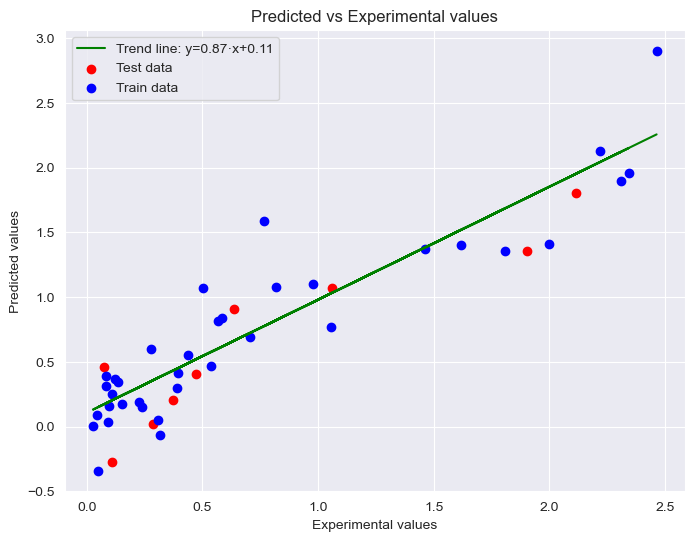

intercept: 0.10805191433631861
slope: 0.8728259146750139


In [16]:
import matplotlib.pyplot as plt

# Строим график
plt.figure(figsize=(8, 6))
# Выполнение линейной аппроксимации
slope, intercept = np.polyfit(y_train, y_train_pred, 1)
plt.plot(y_train, slope * y_train + intercept, color='green', label='Trend line: y=0.87·x+0.11')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')
plt.scatter(y_train, y_train_pred, color='blue', label='Train data')
plt.title('Predicted vs Experimental values')
plt.xlabel('Experimental values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()

print(f"intercept: {intercept}")
print(f"slope: {slope}")

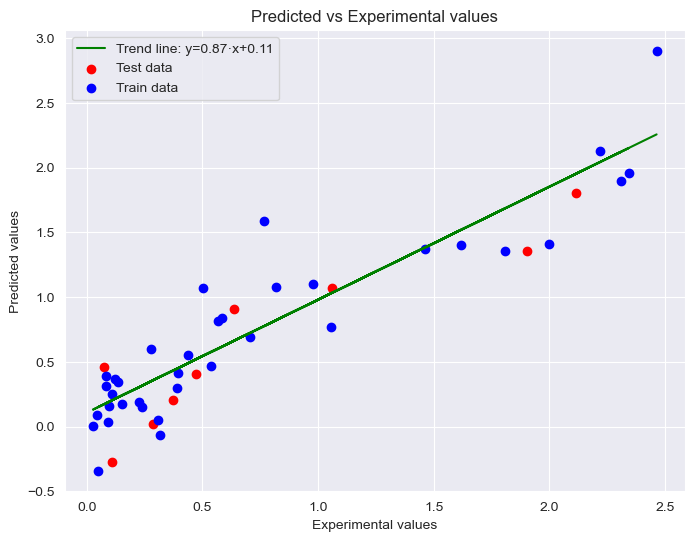

In [17]:
#Сохраняет в PDF в высоком качестве
import matplotlib.pyplot as plt

# Строим график
plt.figure(figsize=(8, 6))
# Выполнение линейной аппроксимации
slope, intercept = np.polyfit(y_train, y_train_pred, 1)
plt.plot(y_train, slope * y_train + intercept, color='green', label='Trend line: y=0.87·x+0.11')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')
plt.scatter(y_train, y_train_pred, color='blue', label='Train data')
plt.title('Predicted vs Experimental values')
plt.xlabel('Experimental values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)

# Сохранение графика в PDF
plt.savefig('Toluene_SVR_graph.pdf')

# Отображение графика (необязательно)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
# Получите стандартизированные коэффициенты регрессии
scaler = StandardScaler()
best_clf.fit(X_train, y_train)
standardized_coefficients = best_clf.coef_

In [19]:
# Определите относительный вклад каждого дескриптора
relative_contributions = np.abs(standardized_coefficients)

In [20]:
# Нормализуйте относительный вклад в процентах
total_contribution = np.sum(relative_contributions)
relative_contributions_percent = (relative_contributions / total_contribution) * 100

In [21]:
# Выводим относительный вклад в процентах
relative_contributions_percent

array([[14.52518764,  7.18894851,  5.86361916, 21.62710961, 12.70174493,
        27.99568022, 10.09770994]])

In [22]:
total_contribution

1.8403012757183888

In [23]:
#Считаем q2
#import pandas as pd
#import numpy as np
#from sklearn.svm import SVR

# Предполагается, что X_train и y_train уже определены и предобработаны

# Создаем пустой датафрейм для предсказаний
#y_predict = pd.DataFrame(columns=['Predicted'])

# Цикл для исключения одного элемента и обучения модели
#for index_to_exclude in X_train.index:
    # Создаем новую выборку, исключая текущий элемент
#    X_train_subset = X_train.drop([index_to_exclude], axis=0)
#    y_train_subset = y_train.drop([index_to_exclude], axis=0)
#    X_solo = X_train.loc[[index_to_exclude]]
    
    # Обучаем модель SVR с линейным ядром
#    model = SVR(kernel='linear', C=300000, epsilon=0.001)
#    model.fit(X_train_subset, y_train_subset)
    
    # Предсказываем значение для исключенного элемента
#    y_pred = model.predict(X_solo)
    
    # Добавляем предсказание в датафрейм
#    y_predict.loc[index_to_exclude] = y_pred

#from sklearn.metrics import r2_score as r2
#q2 = r2(y_train,y_predict)
#print('q2 =', q2)

In [25]:
feature_names = Porphs_data1.columns.values[:-1]

In [26]:
feature_names 

array(['VE1_RG', 'G3u:(Dragon7)', 'MATS8i:(Dragon7)', 'TDB06p:(Dragon7)',
       'X', 'Eig03_EA(dm)', 'Mor23i:(Dragon7)'], dtype=object)

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

In [28]:
svr_ale = ALE(best_clf.predict, feature_names=feature_names, target_names=['LnLn'])

In [29]:
X_train1 = X_train.to_numpy()

In [30]:
svr_exp = svr_ale.explain(X_train1)

C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
C:\Users\plato\anaconda3\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  w

In [33]:
axes = plot_ale(svr_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7});

# Сохранение графика в PDF
plt.savefig('Toluene_SVR_ale_plot.pdf', format='pdf')

# Если необходимо закрыть окно с графиком после сохранения
plt.close()

In [32]:
import shap
shap.initjs()

In [34]:
model = best_clf

In [35]:
explainer = shap.Explainer(model, X_train)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 9

Sample shap value:
.values =
array([ 0.14984101,  0.00583335,  0.02647441, -1.21306977, -0.01845851,
       -0.25570054,  0.28345182])

.base_values =
0.7462209040873983

.data =
array([ 0.65818755,  0.03723361,  0.19207868, -2.98937295, -0.04767451,
       -0.55870445,  1.57190586])


In [36]:
print(f"Sample shap value:\n{shap_test[0]}")
# Вывод ожидаемого (базового) значения
print(f"Expected value: {explainer.expected_value:.1f}")

# Вывод среднего значения целевой переменной в обучающем наборе
print(f"Average target value (training data): {y_train.mean():.1f}")

# Вывод базового значения SHAP
unique_base_values = np.unique(shap_test.base_values)
print(f"Base value: {unique_base_values[0]:.1f}")

Sample shap value:
.values =
array([ 0.14984101,  0.00583335,  0.02647441, -1.21306977, -0.01845851,
       -0.25570054,  0.28345182])

.base_values =
0.7462209040873983

.data =
array([ 0.65818755,  0.03723361,  0.19207868, -2.98937295, -0.04767451,
       -0.55870445,  1.57190586])
Expected value: 0.7
Average target value (training data): 0.7
Base value: 0.7


In [37]:
(shap_test.data == X_test).describe()

,VE1_RG,G3u:(Dragon7),MATS8i:(Dragon7),TDB06p:(Dragon7),X,Eig03_EA(dm),Mor23i:(Dragon7)
count,9,9,9,9,9,9,9
unique,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True
freq,9,9,9,9,9,9,9


In [38]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

,VE1_RG,G3u:(Dragon7),MATS8i:(Dragon7),TDB06p:(Dragon7),X,Eig03_EA(dm),Mor23i:(Dragon7)
SrNo,,,,,,,
2,0.658188,0.037234,0.192079,-2.989373,-0.047675,-0.558704,1.571906
31,0.312659,-0.251817,-0.115910,-0.059252,-0.618974,-0.558704,0.445053
70,-1.443776,-0.413489,-0.433833,0.643087,-0.280807,-0.558704,-1.259714
57,0.774879,-0.511472,0.510002,-1.336810,-0.712645,-0.558704,0.697790
47,-1.030051,-0.168531,-1.188901,-0.017938,1.540987,-0.558704,-0.017761
39,-1.175537,-0.310607,-0.185455,0.452407,-0.641601,1.270692,-1.141394
42,-0.922453,-0.452682,0.162273,-0.542309,-0.845697,1.880491,-0.224619
66,-0.389006,-0.535968,1.741955,1.351782,0.978903,-0.558704,-0.039494
53,-0.299593,-0.320405,1.235265,0.392025,-0.499013,2.447299,-1.708040


In [39]:
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,VE1_RG,G3u:(Dragon7),MATS8i:(Dragon7),TDB06p:(Dragon7),X,Eig03_EA(dm),Mor23i:(Dragon7)
SrNo,,,,,,,
2,0.149841,0.005833,0.026474,-1.213070,-0.018459,-0.255701,0.283452
31,0.057479,0.044074,-0.006760,-0.046870,-0.152000,-0.255701,0.074051
70,-0.412029,0.065463,-0.041067,0.232664,-0.072953,-0.255701,-0.242743
57,0.181034,0.078426,0.060781,-0.555343,-0.173896,-0.255701,0.121016
47,-0.301437,0.033056,-0.122545,-0.030427,0.352892,-0.255701,-0.011953
39,-0.340327,0.051852,-0.014265,0.156772,-0.157289,0.686813,-0.220756
42,-0.272676,0.070648,0.023258,-0.239129,-0.204997,1.000985,-0.050393
66,-0.130081,0.081667,0.193719,0.514727,0.221504,-0.255701,-0.015992
53,-0.106181,0.053148,0.139043,0.132740,-0.123959,1.293007,-0.326055


In [40]:
# Получаем ожидаемое значение как скаляр (если это действительно нужно)
expected_value = explainer.expected_value

# Выполняем операции с предсказаниями, ожидаемым значением и суммой SHAP
predictions = model.predict(X_test)
shap_sum = shap_df.sum(axis=1)

# Проверяем близость между предсказаниями и целевым выражением
np.isclose(predictions, expected_value + shap_sum)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [41]:
columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index

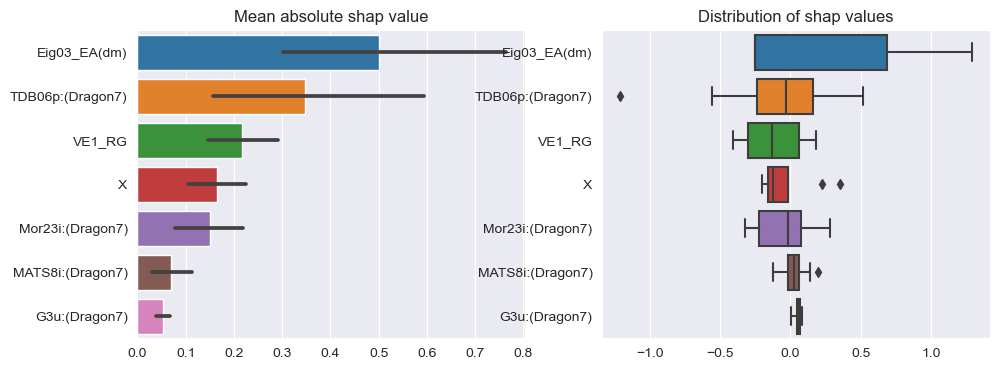

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

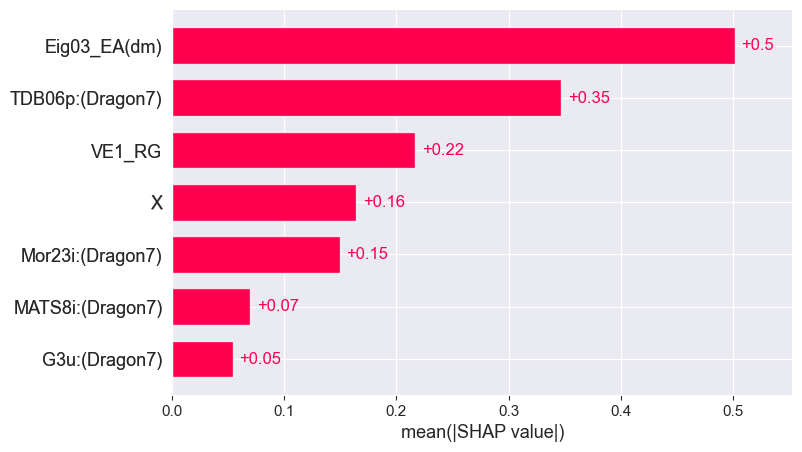

In [43]:
shap.plots.bar(shap_test)

In [44]:
import shap
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть обученная модель, X_test и shap_values

# Создаем фигуру
plt.figure()

# Построение SHAP summary plot
shap.summary_plot(shap_test, X_test, show=False)  # Убедитесь, что show=False

# Сохранение графика в PDF
plt.savefig('Toluene_SVR_SHAP_test_plot.pdf', format='pdf')

# Если необходимо закрыть окно с графиком после сохранения
plt.close()